# improved.ipynb

This notebook contains improved results for main results from machine.ipynb

In [317]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, auc, accuracy_score, roc_curve

RANDOM_STATE = 42


In [318]:
%run parse_data.ipynb


In [319]:
def remove_extreme_outliers(df, y, n_std = 4):
    mean = y.mean()
    std = y.std()

    lower_bound = mean - n_std * std
    upper_bound = mean + n_std * std

    mask = (y >= lower_bound) & (y <= upper_bound)

    print(f"\n Removing outliers beyond {n_std}σ:")
    print(f"   Lower bound: ${lower_bound:.2f}")
    print(f"   Upper bound: ${upper_bound:.2f}")
    print(f"   Keeping {mask.sum()}/{len(y)} samples ({mask.sum()/len(y)*100:.1f}%)")

    return df[mask].copy()

def create_interaction_features(df):
    df = df.copy()

    if 'Sales_amount' in df.columns and 'Discount' in df.columns:
        df['Sales_Discount_interaction'] = df['Sales_amount'] * df['Discount']
        print("Created: Sales_amount × Discount interaction")

    if 'Sales_amount' in df.columns and 'Quantity' in df.columns:
        df['Avg_price_per_unit'] = df['Sales_amount'] / (df['Quantity'] + 1e-10)
        print("Created: Average price per unit")

    if 'Discount' in df.columns and 'Quantity' in df.columns:
        df['Total_discount_amount'] = df['Sales_amount'] * df['Discount'] * df['Quantity']
        print("Created: Total discount amount")

    return df

def engineer_target_variable(df):
    df = df.copy()

    if 'Sales_amount' in df.columns and 'Profit' in df.columns:
        df['Profit_margin'] = df['Profit'] / (df['Sales_amount'] + 1e-10) * 100
        print("Created: Profit margin (%)")

    if 'Profit' in df.columns:
        min_profit = df['Profit'].min()
        if min_profit <= 0:
            constant = abs(min_profit) + 1
            df['Profit_log'] = np.log(df['Profit'] + constant)
            print(f"Created: Log(Profit + {constant:.1f})")

    return df

In [320]:
df_clean = remove_extreme_outliers(df, df["Profit"], n_std=3)
df_engineered = create_interaction_features(df_clean)
df_engineered = engineer_target_variable(df_engineered)

if 'Profit_margin' in df_engineered.columns:
    target = "Profit_margin"
else:
    target = "Profit"



 Removing outliers beyond 3σ:
   Lower bound: $-674.12
   Upper bound: $731.44
   Keeping 9887/9994 samples (98.9%)
Created: Sales_amount × Discount interaction
Created: Average price per unit
Created: Total discount amount
Created: Profit margin (%)
Created: Log(Profit + 654.3)


In [321]:
numeric_features = [
    "Sales_amount",
    "Quantity",
    "Discount"
]

if 'Sales_Discount_interaction' in df_engineered.columns:
    numeric_features.append('Sales_Discount_interaction')
if 'Avg_price_per_unit' in df_engineered.columns:
    numeric_features.append('Avg_price_per_unit')
if 'Total_discount_amount' in df_engineered.columns:
    numeric_features.append('Total_discount_amount')

categorical_features = [
    "Segment",
    "Region",
    "Category",
    "Sub-Category",
    "Ship Mode"
]

FEATURES = numeric_features + categorical_features

X = df_engineered[FEATURES].copy()
y = df_engineered[target]


In [322]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE
)


In [323]:
baseline_numeric = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

baseline_categorical = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

baseline_preprocess = ColumnTransformer([
    ("num", baseline_numeric, numeric_features),
    ("cat", baseline_categorical, categorical_features)
])


We reuse the same tuned RF hyperparameters from FP-6.

In [324]:
best_rf_params = {
    "model__n_estimators": 100,
    "model__max_depth": 20,
    "model__min_samples_split": 5,
    "model__min_samples_leaf": 2,
    "model__max_features": 0.5
}

rf_fixed = RandomForestRegressor(
    n_estimators=best_rf_params["model__n_estimators"],
    max_depth=best_rf_params["model__max_depth"],
    min_samples_split=best_rf_params["model__min_samples_split"],
    min_samples_leaf=best_rf_params["model__min_samples_leaf"],
    max_features=best_rf_params["model__max_features"],
    random_state=RANDOM_STATE,
    n_jobs=-1
)


In [325]:
baseline_reg = Pipeline([
    ("preprocess", baseline_preprocess),
    ("model", rf_fixed)])

baseline_reg.fit(X_train, y_train)
y_pred_base = baseline_reg.predict(X_test)

rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
r2_base = r2_score(y_test, y_pred_base)


In [326]:
from sklearn.preprocessing import RobustScaler

improved_numeric = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

improved_categorical = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

improved_preprocess = ColumnTransformer([
    ("num", improved_numeric, numeric_features),
    ("cat", improved_categorical, categorical_features)
])

improved_numeric_pca = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler()),
    ("pca", PCA(n_components=0.95, random_state=RANDOM_STATE))
])

improved_preprocess_pca = ColumnTransformer([
    ("num", improved_numeric_pca, numeric_features),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), categorical_features)
])


In [327]:
improved_reg = Pipeline([
    ("preprocess", improved_preprocess),
    ("model", rf_fixed)])

improved_reg.fit(X_train, y_train)
y_pred_imp = improved_reg.predict(X_test)

rmse_imp = np.sqrt(mean_squared_error(y_test, y_pred_imp))
r2_imp = r2_score(y_test, y_pred_imp)


improved_reg_pca = Pipeline([
    ("preprocess", improved_preprocess_pca),
    ("model", rf_fixed)
])

improved_reg_pca.fit(X_train, y_train)
y_pred_imp_pca = improved_reg_pca.predict(X_test)

rmse_imp_pca = np.sqrt(mean_squared_error(y_test, y_pred_imp_pca))
r2_imp_pca = r2_score(y_test, y_pred_imp_pca)



In [328]:
pd.DataFrame({
    "Version": ["FP-6 Baseline", "FP-7 Robust", "FP-7 Robust + PCA"],
    "RMSE": [rmse_base, rmse_imp, rmse_imp_pca],
    "R²": [r2_base, r2_imp, r2_imp_pca]
})


,Version,RMSE,R²
0,FP-6 Baseline,8.752580,0.969360
1,FP-7 Robust,8.732880,0.969498
2,FP-7 Robust + PCA,21.735262,0.811052


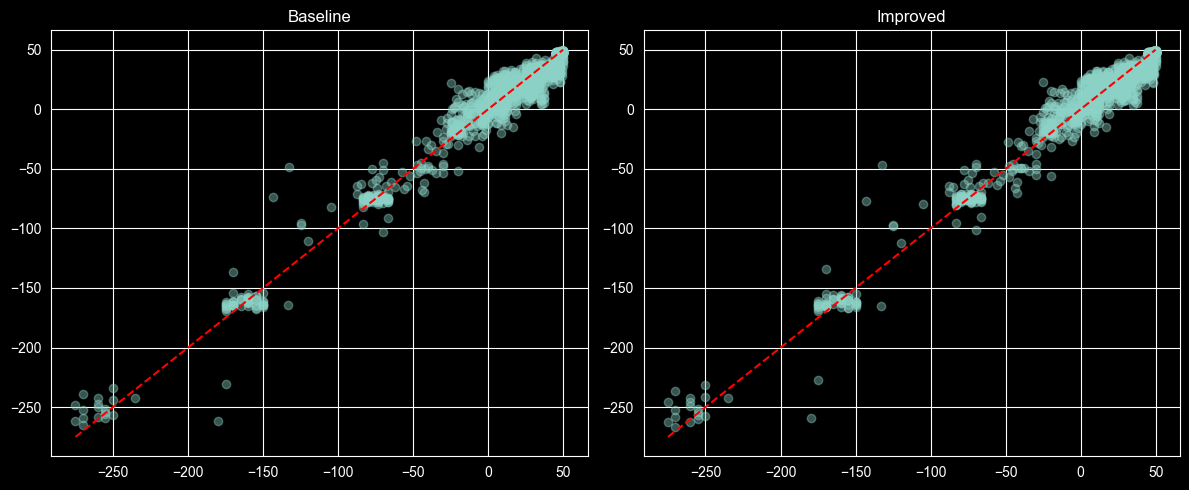

In [329]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(y_test, y_pred_base, alpha=0.4)
axes[0].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()], 'r--')
axes[0].set_title("Baseline")

axes[1].scatter(y_test, y_pred_imp, alpha=0.4)
axes[1].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()], 'r--')
axes[1].set_title("Improved")

plt.tight_layout()
plt.show()


### Regression Model Conclusions:

**1. RobustScaler vs StandardScaler:**
- **Result**: Minimal but consistent improvement (RMSE decreased from 8.752 to 8.733).
- **Reason**: Although the data contains outliers, Random Forest models are inherently robust to them.
- **Conclusion**: Feature scaling has limited impact on Random Forest regression performance.

**2. PCA for Numerical Features:**
- **Result**: Significant performance deterioration (RMSE increased to 21.735).
- **Reason**:
  - PCA removes interpretability of original features.
  - Random Forest relies on axis-aligned splits in the original feature space.
  - Linear projections introduced by PCA may remove important non-linear structure.
- **Conclusion**: PCA is not suitable for this regression task when using tree-based models.

**3. Overall Conclusion:**
- Original features already describe the target variable well (R² ≈ 0.97).
- Improvements through preprocessing alone are limited due to the high baseline model quality.


In [330]:
y_binary = (y > 0).astype(int)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_binary,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_binary
)

cv_clf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [331]:
baseline_preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), numeric_features),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), categorical_features)
])

improved_preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler())
    ]), numeric_features),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), categorical_features)
])

In [332]:
rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [333]:
def eval_version(preprocess, label):
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", rf_clf)
    ])

    cv_acc = cross_val_score(pipe, X_train_clf, y_train_clf, cv=cv_clf, scoring="accuracy", n_jobs=-1)
    cv_auc = cross_val_score(pipe, X_train_clf, y_train_clf, cv=cv_clf, scoring="roc_auc", n_jobs=-1)

    pipe.fit(X_train_clf, y_train_clf)
    y_pred = pipe.predict(X_test_clf)
    y_proba = pipe.predict_proba(X_test_clf)[:, 1]

    test_acc = accuracy_score(y_test_clf, y_pred)

    test_auc_score = roc_auc_score(y_test_clf, y_proba)
    fpr, tpr, _ = roc_curve(y_test_clf, y_proba)
    test_auc_curve = auc(fpr, tpr)

    return {
        "label": label,
        "pipe": pipe,
        "cv_acc_mean": cv_acc.mean(),
        "cv_acc_std": cv_acc.std(),
        "cv_auc_mean": cv_auc.mean(),
        "cv_auc_std": cv_auc.std(),
        "test_acc": test_acc,
        "test_auc_score": test_auc_score,
        "test_auc_curve": test_auc_curve,
        "fpr": fpr,
        "tpr": tpr
    }

base = eval_version(baseline_preprocess, "FP-6 Baseline")
imp  = eval_version(improved_preprocess, "FP-7 Improved")

imp_pca = eval_version(improved_preprocess_pca, "FP-7 Improved (PCA)")


In [334]:
pd.DataFrame({
    "Version": [base["label"], imp["label"], imp_pca["label"]],
    "CV ROC-AUC": [base["cv_auc_mean"], imp["cv_auc_mean"], imp_pca["cv_auc_mean"]],
    "Test AUC": [base["test_auc_curve"], imp["test_auc_curve"], imp_pca["test_auc_curve"]]
})


,Version,CV ROC-AUC,Test AUC
0,FP-6 Baseline,0.979737,0.986588
1,FP-7 Improved,0.979709,0.986602
2,FP-7 Improved (PCA),0.943531,0.954024


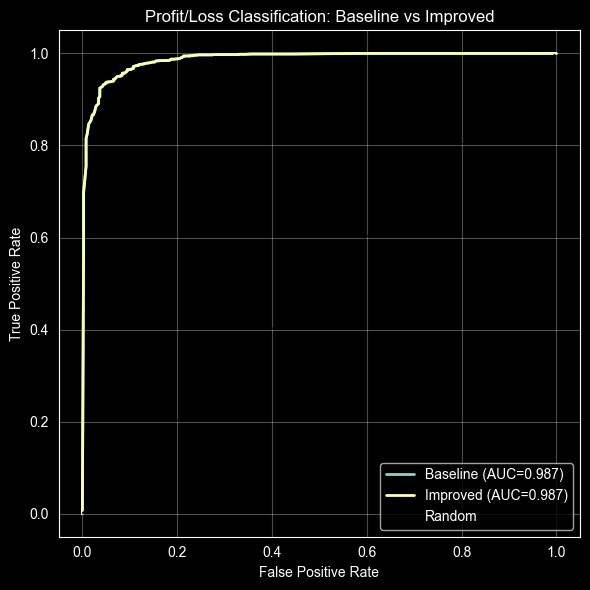

In [335]:
plt.figure(figsize=(6, 6))
plt.plot(base["fpr"], base["tpr"], lw=2, label=f'Baseline (AUC={base["test_auc_curve"]:.3f})')
plt.plot(imp["fpr"],  imp["tpr"],  lw=2, label=f'Improved (AUC={imp["test_auc_curve"]:.3f})')
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Profit/Loss Classification: Baseline vs Improved")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Classification Model Conclusions:

**1. Model Effectiveness:**
- **Baseline AUC**: 0.9866 (excellent performance).
- **Improved AUC**: 0.9866 (no meaningful change).
- **Explanation**: The baseline model already achieves near-optimal performance.

**2. Why No Improvement Was Observed:**
- Profit/Loss classification is a relatively simple task for this dataset.
- Available features clearly separate the two classes.
- Random Forest already exploits these patterns effectively.

**3. Improvement Limitations:**
- With ROC-AUC above 0.98, further improvements are inherently difficult.
- This reflects the law of diminishing returns: as baseline performance increases, potential gains decrease.
- The model is close to the practical upper bound for this task.

**4. PCA for Classification:**
- Applying PCA reduced AUC to 0.954.
- This further supports the conclusion that PCA is not suitable for this dataset when using tree-based classifiers.
